<a href="https://colab.research.google.com/github/princenishad5471/Projects_Resume_Tnp/blob/main/Geopolicts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance hmmlearn matplotlib pandas numpy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.7 MB/s eta 0:00:00


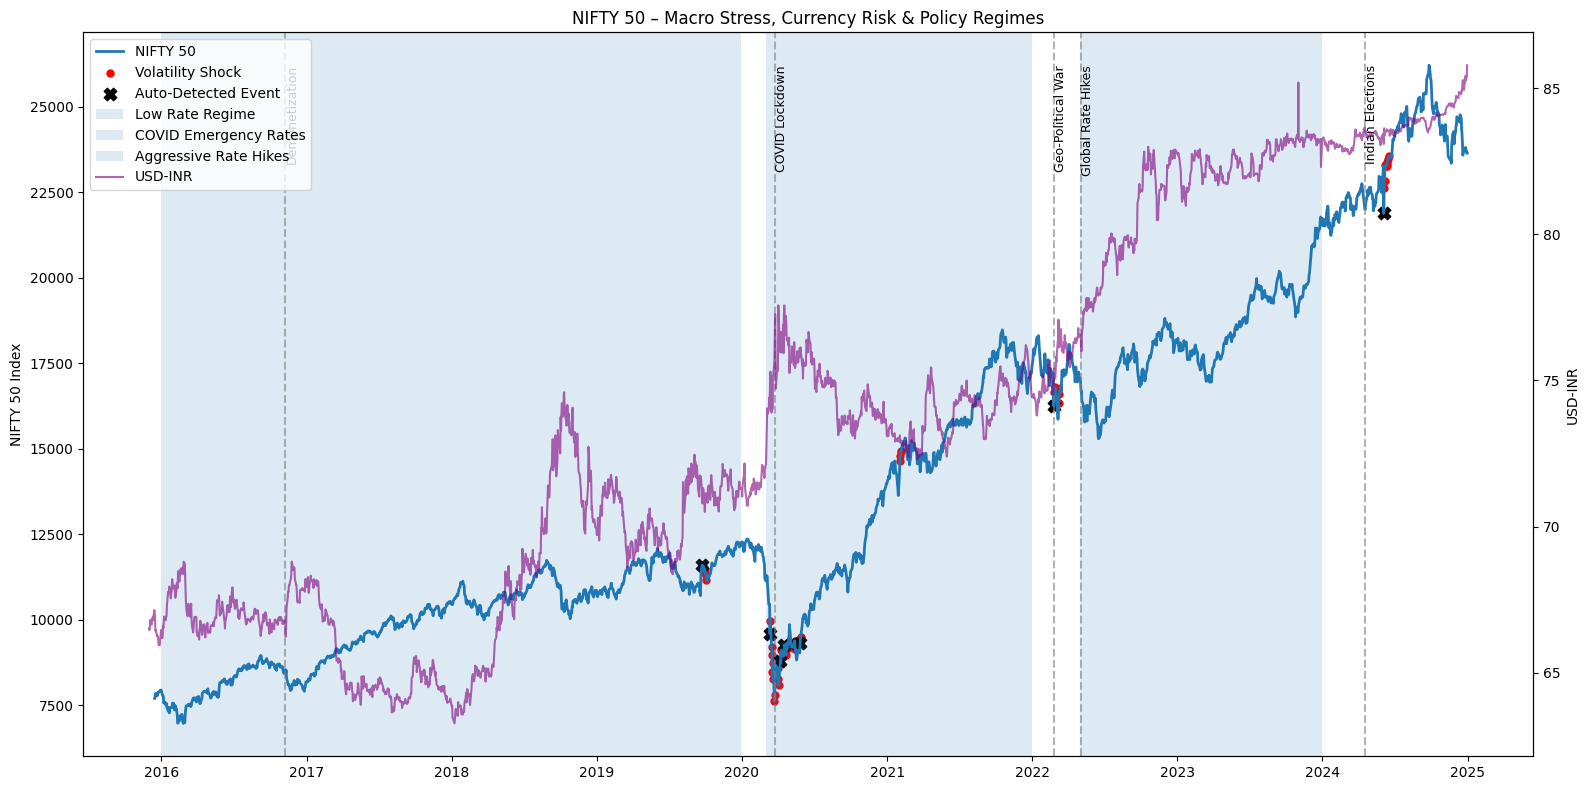

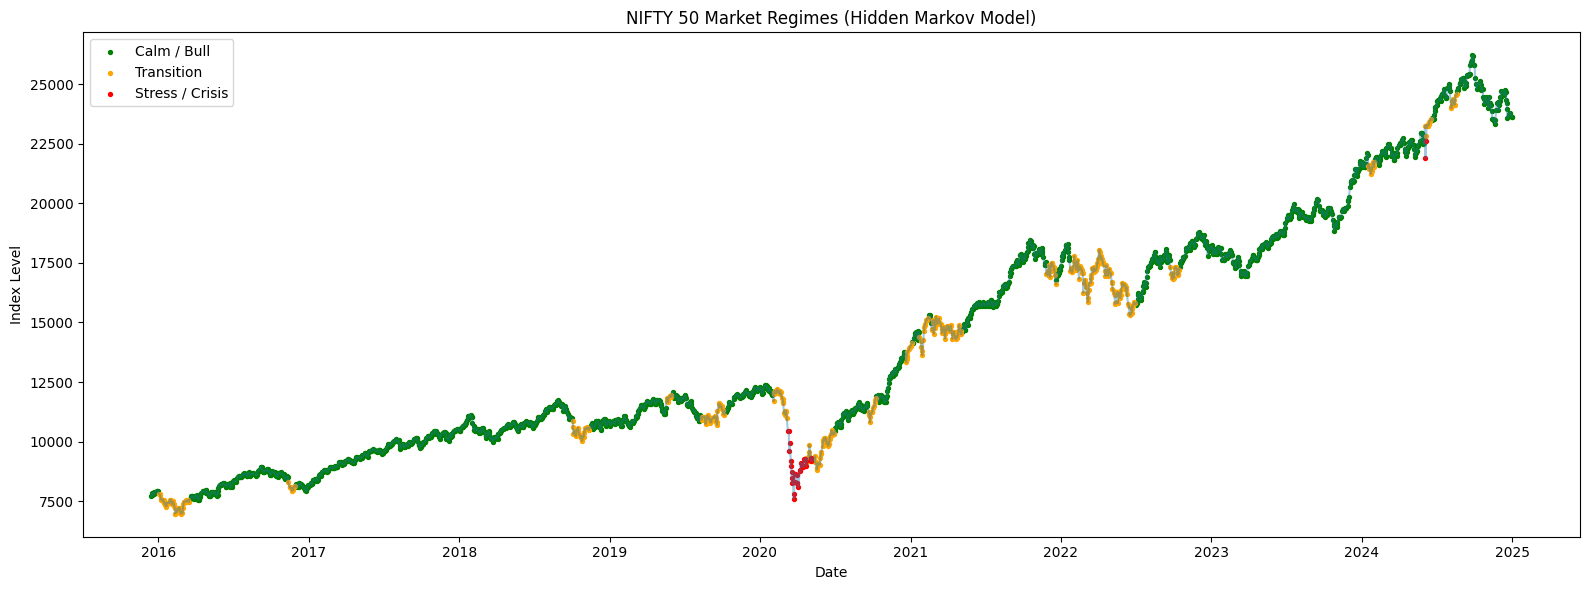

In [2]:
# ======================================================
# NIFTY 50 MACRO STRESS & MARKET REGIME ANALYSIS
# ======================================================

from __future__ import annotations
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from hmmlearn.hmm import GaussianHMM

# ======================================================
# CONFIG
# ======================================================

@dataclass(frozen=True)
class Config:
    start_date: str = "2015-12-01"
    end_date: str = "2025-01-01"
    vol_window: int = 10


CFG = Config()

# ======================================================
# DATA LOADERS
# ======================================================

def load_nifty() -> pd.DataFrame:
    df = yf.download("^NSEI", start=CFG.start_date, end=CFG.end_date, progress=False)
    df.reset_index(inplace=True)
    df.rename(columns={"Date": "date", "Close": "close", "Volume": "volume"}, inplace=True)
    return df[["date", "close", "volume"]]


def load_usdinr() -> pd.DataFrame:
    df = yf.download("INR=X", start=CFG.start_date, end=CFG.end_date, progress=False)
    df.reset_index(inplace=True)
    df.rename(columns={"Date": "date", "Close": "usdinr"}, inplace=True)
    return df[["date", "usdinr"]]


def load_macro_events() -> pd.DataFrame:
    return pd.DataFrame(
        {
            "date": pd.to_datetime(
                [
                    "2016-11-08",  # Demonetization
                    "2020-03-24",  # COVID Lockdown
                    "2022-02-24",  # Russia–Ukraine War
                    "2022-05-04",  # Global Rate Hikes
                    "2024-04-19",  # Indian Elections
                ]
            ),
            "label": [
                "Demonetization",
                "COVID Lockdown",
                "Geo-Political War",
                "Global Rate Hikes",
                "Indian Elections",
            ],
        }
    )


def load_repo_rate_regimes():
    return [
        ("2016-01-01", "2019-12-31", "Low Rate Regime"),
        ("2020-03-01", "2021-12-31", "COVID Emergency Rates"),
        ("2022-05-01", "2023-12-31", "Aggressive Rate Hikes"),
    ]

# ======================================================
# FEATURE ENGINEERING & STRESS SIGNALS
# ======================================================

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["return_1d"] = df["close"].pct_change()
    df["rolling_vol"] = df["return_1d"].rolling(CFG.vol_window).std()

    vol_mean = df["rolling_vol"].mean()
    vol_std = df["rolling_vol"].std()

    df["vol_spike"] = df["rolling_vol"] > (vol_mean + 2 * vol_std)
    return df.dropna()

# ======================================================
# AUTOMATIC EVENT DISCOVERY
# ======================================================

def discover_market_events(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    ret_mean = df["return_1d"].mean()
    ret_std = df["return_1d"].std()

    df["return_event"] = df["return_1d"].abs() > (ret_mean + 2.5 * ret_std)
    df["systemic_event"] = df["vol_spike"] & df["return_event"]

    return df


def cluster_events(df: pd.DataFrame, min_gap: int = 5) -> pd.DataFrame:
    events = df[df["systemic_event"]].copy()
    if events.empty:
        return events

    events["group"] = (events["date"].diff().dt.days > min_gap).cumsum()
    return events.groupby("group").first().reset_index(drop=True)

# ======================================================
# BEST-SUITED MODEL: HIDDEN MARKOV MODEL
# ======================================================

def detect_market_regimes_hmm(df: pd.DataFrame, n_states: int = 3) -> pd.DataFrame:
    df = df.copy()

    X = np.column_stack([df["return_1d"], df["rolling_vol"]])

    model = GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        random_state=42,
    )

    model.fit(X)
    df["regime_raw"] = model.predict(X)

    # Rank regimes by volatility
    order = (
        df.groupby("regime_raw")["rolling_vol"]
        .mean()
        .sort_values()
        .index
        .tolist()
    )

    mapping = {old: new for new, old in enumerate(order)}
    df["regime"] = df["regime_raw"].map(mapping)

    return df

# ======================================================
# MASTER VISUALIZATION DASHBOARD
# ======================================================

def plot_macro_dashboard(
    nifty: pd.DataFrame,
    usdinr: pd.DataFrame,
    events: pd.DataFrame,
    repo_regimes,
    auto_events: pd.DataFrame,
) -> None:

    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Price
    ax1.plot(nifty["date"], nifty["close"], label="NIFTY 50", linewidth=2)

    # Volatility stress
    stress = nifty[nifty["vol_spike"]]
    ax1.scatter(
        stress["date"], stress["close"],
        color="red", s=25, label="Volatility Shock"
    )

    # Auto-detected events
    if not auto_events.empty:
        ax1.scatter(
            auto_events["date"], auto_events["close"],
            color="black", s=80, marker="X", label="Auto-Detected Event"
        )

    # Macro events
    for _, row in events.iterrows():
        ax1.axvline(row["date"], linestyle="--", color="gray", alpha=0.6)
        ax1.text(
            row["date"], nifty["close"].max(),
            row["label"], rotation=90, fontsize=9, va="top"
        )

    # Repo regimes
    for start, end, label in repo_regimes:
        ax1.axvspan(
            pd.to_datetime(start), pd.to_datetime(end),
            alpha=0.15, label=label
        )

    ax1.set_ylabel("NIFTY 50 Index")

    # USD-INR overlay
    ax2 = ax1.twinx()
    ax2.plot(usdinr["date"], usdinr["usdinr"], color="purple", alpha=0.6, label="USD-INR")
    ax2.set_ylabel("USD-INR")

    # Legend merge
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.title("NIFTY 50 – Macro Stress, Currency Risk & Policy Regimes")
    plt.tight_layout()
    plt.show()


def plot_market_regimes(df: pd.DataFrame) -> None:
    plt.figure(figsize=(16, 6))

    colors = {0: "green", 1: "orange", 2: "red"}
    labels = {
        0: "Calm / Bull",
        1: "Transition",
        2: "Stress / Crisis",
    }

    for r in colors:
        subset = df[df["regime"] == r]
        plt.scatter(
            subset["date"], subset["close"],
            color=colors[r], s=8, label=labels[r]
        )

    plt.plot(df["date"], df["close"], alpha=0.4)
    plt.title("NIFTY 50 Market Regimes (Hidden Markov Model)")
    plt.xlabel("Date")
    plt.ylabel("Index Level")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ======================================================
# MAIN
# ======================================================

def main():
    nifty = load_nifty()
    usdinr = load_usdinr()
    events = load_macro_events()
    repo_regimes = load_repo_rate_regimes()

    nifty = engineer_features(nifty)
    nifty = discover_market_events(nifty)
    auto_events = cluster_events(nifty)
    nifty = detect_market_regimes_hmm(nifty)

    plot_macro_dashboard(
        nifty=nifty,
        usdinr=usdinr,
        events=events,
        repo_regimes=repo_regimes,
        auto_events=auto_events,
    )

    plot_market_regimes(nifty)


if __name__ == "__main__":
    main()
